# Instacart Recommendation System: Feature Engineering and Modeling

## Notebook by Lauren Dellon

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from library.sb_utils import save_file

## Read files

In [2]:
aisles = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/aisles.csv')
departments = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/departments.csv')
products = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/products.csv')
orders = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/orders.csv')
order_products_prior = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/order_products__prior.csv')
order_products_train = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/order_products__train.csv')

## Merge order_products_prior with orders

In [3]:
order_products_complete = pd.merge(order_products_prior, orders, on='order_id')
order_products_complete.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


## Merge products with aisles and departments

In [4]:
products_merged = pd.merge(products, aisles, on='aisle_id', how='left')
products_merged = pd.merge(products_merged, departments, on='department_id', how='left')
products_merged.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


## Merge order_products_prior with products_merged

In [5]:
order_products_merged = pd.merge(order_products_prior, products_merged, on='product_id')
order_products_merged.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,Organic Egg Whites,86,16,eggs,dairy eggs


## CREATING FEATURES FOR USERS

### Reordered ratio of each user

In [6]:
user_reorder_ratio = pd.DataFrame(order_products_complete.groupby('user_id')['reordered'].aggregate('mean')).reset_index()
user_reorder_ratio = user_reorder_ratio.rename(columns={'reordered':'user_reorder_ratio'})

### Total number of orders of each user

In [7]:
user_total_orders = pd.DataFrame(order_products_complete.groupby('user_id')['order_number'].aggregate('max')).reset_index()
user_total_orders = user_total_orders.rename(columns={'order_number':'user_total_orders'})

### Total items purchased by each user

In [8]:
user_total_items = pd.DataFrame(order_products_complete.groupby('user_id')['add_to_cart_order'].aggregate('count')).reset_index()
user_total_items = user_total_items.rename(columns={'add_to_cart_order':'user_total_items'})

### Average days since prior order for each user

In [9]:
user_avg_days = pd.DataFrame(order_products_complete.groupby(['user_id'])['days_since_prior_order'].aggregate('mean')).reset_index()
user_avg_days = user_avg_days.rename(columns={'days_since_prior_order':'user_avg_days'})

### Average basket size of each user


In [10]:
basket_size = pd.DataFrame(order_products_complete.groupby(['user_id','order_number'])['add_to_cart_order'].aggregate('max')).reset_index()
user_avg_basket_size = pd.DataFrame(basket_size.groupby(['user_id'])['add_to_cart_order'].aggregate('mean')).reset_index()
user_avg_basket_size = user_avg_basket_size.rename(columns={'add_to_cart_order':'user_avg_basket_size'})

### Merge all features for users

In [11]:
user_features = user_reorder_ratio.merge(user_total_orders, on='user_id', how='left')
user_features = user_features.merge(user_total_items, on='user_id', how='left')
user_features = user_features.merge(user_avg_days, on='user_id', how='left')
user_features = user_features.merge(user_avg_basket_size, on='user_id', how='left')
user_features.head()

,user_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size
0,1,0.694915,10,59,20.259259,5.900000
1,2,0.476923,14,195,15.967033,13.928571
2,3,0.625000,12,88,11.487179,7.333333
3,4,0.055556,5,18,15.357143,3.600000
4,5,0.378378,4,37,14.500000,9.250000


## CREATING FEATURE FOR PRODUCTS

### Reordered ratio of each product

In [12]:
prod_reorder_ratio = pd.DataFrame(order_products_complete.groupby('product_id')['reordered'].agg('mean')).reset_index()
prod_reorder_ratio = prod_reorder_ratio.rename(columns={'reordered':'prod_reorder_ratio'})

### Number of purchases of each product

In [13]:
prod_num_purchases = pd.DataFrame(order_products_complete.groupby('product_id')['order_id'].agg('count')).reset_index()
prod_num_purchases = prod_num_purchases.rename(columns={'order_id':'prod_num_purchases'})

### Merge all features for products

In [14]:
prod_features = prod_reorder_ratio.merge(prod_num_purchases, on='product_id', how='left')
prod_features.head()

,product_id,prod_reorder_ratio,prod_num_purchases
0,1,0.613391,1852
1,2,0.133333,90
2,3,0.732852,277
3,4,0.446809,329
4,5,0.600000,15


## Create dataframe of users and products

In [15]:
user_products = order_products_complete[['user_id','product_id']]
user_products = user_products.sort_values(by=['user_id','product_id'])
user_products = user_products.drop_duplicates()
user_products = user_products.reset_index(drop=True)
user_products.head()

,user_id,product_id
0,1,196
1,1,10258
2,1,10326
3,1,12427
4,1,13032


## Merge user_products with user features and product features

In [16]:
features_df = user_products.merge(user_features, on='user_id', how='left')
features_df = features_df.merge(prod_features, on='product_id', how='left')
features_df.head()

,user_id,product_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size,prod_reorder_ratio,prod_num_purchases
0,1,196,0.694915,10,59,20.259259,5.9,0.776480,35791
1,1,10258,0.694915,10,59,20.259259,5.9,0.713772,1946
2,1,10326,0.694915,10,59,20.259259,5.9,0.652009,5526
3,1,12427,0.694915,10,59,20.259259,5.9,0.740735,6476
4,1,13032,0.694915,10,59,20.259259,5.9,0.657158,3751


## Merge features_df with original product attributes

In [17]:
features_df = features_df.merge(products_merged, on='product_id', how='left')
# Drop irrelevant columns
features_df = features_df.drop(columns=['product_name','aisle','department'])
features_df.head()

,user_id,product_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size,prod_reorder_ratio,prod_num_purchases,aisle_id,department_id
0,1,196,0.694915,10,59,20.259259,5.9,0.776480,35791,77,7
1,1,10258,0.694915,10,59,20.259259,5.9,0.713772,1946,117,19
2,1,10326,0.694915,10,59,20.259259,5.9,0.652009,5526,24,4
3,1,12427,0.694915,10,59,20.259259,5.9,0.740735,6476,23,19
4,1,13032,0.694915,10,59,20.259259,5.9,0.657158,3751,121,14


## Locate training orders

In [18]:
orders_train_test = orders.loc[orders.eval_set == 'train']
orders_train_test = features_df.merge(orders_train_test, on='user_id', how='left')
orders_train_test = orders_train_test.merge(order_products_train, on=['product_id','order_id'], how='left')
# Drop unnecessary columns
orders_train_test = orders_train_test.drop(['order_id','eval_set','add_to_cart_order'],axis=1)
# Fill NaN's with 0
orders_train_test = orders_train_test.fillna(0)
orders_train_test.head()

,user_id,product_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size,prod_reorder_ratio,prod_num_purchases,aisle_id,department_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,0.694915,10,59,20.259259,5.9,0.776480,35791,77,7,11.0,4.0,8.0,14.0,1.0
1,1,10258,0.694915,10,59,20.259259,5.9,0.713772,1946,117,19,11.0,4.0,8.0,14.0,1.0
2,1,10326,0.694915,10,59,20.259259,5.9,0.652009,5526,24,4,11.0,4.0,8.0,14.0,0.0
3,1,12427,0.694915,10,59,20.259259,5.9,0.740735,6476,23,19,11.0,4.0,8.0,14.0,0.0
4,1,13032,0.694915,10,59,20.259259,5.9,0.657158,3751,121,14,11.0,4.0,8.0,14.0,1.0


## Mean encoding categorical variables (aisle_id and department_id)

In [19]:
cols = ['aisle_id','department_id']
for col in cols:
    mean = orders_train_test.groupby(col).reordered.mean()
    orders_train_test[col] = orders_train_test[col].map(mean)
orders_train_test.head()

,user_id,product_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size,prod_reorder_ratio,prod_num_purchases,aisle_id,department_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,0.694915,10,59,20.259259,5.9,0.776480,35791,0.081894,0.080516,11.0,4.0,8.0,14.0,1.0
1,1,10258,0.694915,10,59,20.259259,5.9,0.713772,1946,0.044555,0.056200,11.0,4.0,8.0,14.0,1.0
2,1,10326,0.694915,10,59,20.259259,5.9,0.652009,5526,0.107899,0.081928,11.0,4.0,8.0,14.0,0.0
3,1,12427,0.694915,10,59,20.259259,5.9,0.740735,6476,0.061736,0.056200,11.0,4.0,8.0,14.0,0.0
4,1,13032,0.694915,10,59,20.259259,5.9,0.657158,3751,0.058826,0.054128,11.0,4.0,8.0,14.0,1.0


## Split orders into training set and testing set

In [20]:
orders_train = orders_train_test.sample(frac=0.7,random_state=123)
orders_test = orders_train_test.drop(orders_train.index)
len(orders_train),len(orders_test)

(9315567, 3992386)

## Creating X_train, y_train, X_test, y_test

In [33]:
X_train = orders_train.drop(['reordered'],axis=1)
y_train = orders_train.reordered
X_test = orders_test.drop(['reordered'],axis=1)
y_test = orders_test.reordered

In [34]:
X_train = X_train.set_index(['user_id','product_id'])
X_test = X_test.set_index(['user_id','product_id'])

## Checking histograms

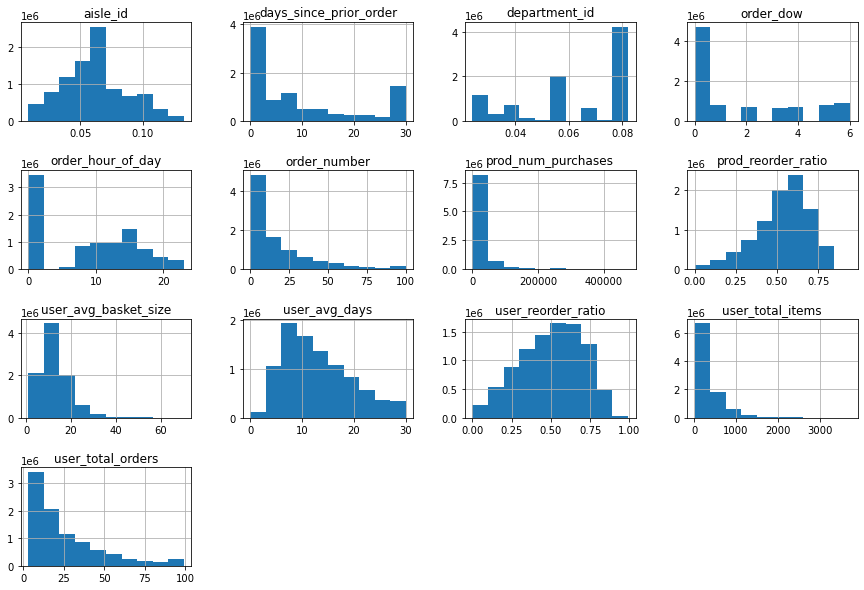

In [35]:
X_train.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

## Scaling

In [36]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# MODELING

## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
# Fit the model on the training data.
clf.fit(X_train, y_train)

# Print the accuracy from the testing data.
print(accuracy_score(y_test, clf.predict(X_test)))

0.9377024165499027


The accuracy without tuning the regularization parameter C is 0.9377.

In [38]:
# Tuning the regularization parameter, C

C_param_range = [0.001,0.01,0.1,1,10,100]
C_param_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
C_param_table['C_parameter'] = C_param_range

j = 0
for C in C_param_range:
    
    # Apply logistic regression model to training data
    logreg = LogisticRegression(C = C,random_state = 40)
    logreg.fit(X_train,y_train)
    
    # Predict using model
    y_pred_lr = logreg.predict(X_test)
    
    # Saving accuracy score in table
    C_param_table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
C_param_table

,C_parameter,Accuracy
0,0.001,0.937674
1,0.010,0.937702
2,0.100,0.937701
3,1.000,0.937702
4,10.000,0.937703
5,100.000,0.937704


The best C is 100.

In [39]:
import timeit

# Using the best regularization parameter from above
logreg = LogisticRegression(C=100)
start = timeit.default_timer()
logreg.fit(X_train, y_train)
stop = timeit.default_timer()
print('Time: ', stop-start)

Time:  25.149286432000054


In [40]:
start = timeit.default_timer()
y_pred_lr = logreg.predict(X_test)
stop = timeit.default_timer()
print('Time: ', stop-start)
accuracy_lr = logreg.score(X_test,y_test)

# Print the accuracy from the testing data.
print(accuracy_lr)

Time:  0.13961148099997445
0.9377036689338155


In [41]:
from sklearn.metrics import confusion_matrix

conf_matrix= confusion_matrix(y_test,y_pred_lr)
print(conf_matrix)

[[3743279     298]
 [ 248413     396]]


There are a lot of false negatives.

In [42]:
from sklearn.metrics import precision_score

precision_lr = precision_score(y_test,y_pred_lr)
print(precision_lr)

0.5706051873198847


In [43]:
from sklearn.metrics import recall_score

recall_lr = recall_score(y_test,y_pred_lr)
print(recall_lr)

0.0015915822980679959


The recall for logistic regression is very poor.

In [44]:
from sklearn.model_selection import cross_val_score

# Compute the ROC-AUC scores from cross-validation
cv_scores_test= cross_val_score(logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.82120698 0.82310366 0.82189754 0.82226782 0.81917124]
Mean cross validation train score: 0.821743983429705
Mean cross validation test score: 0.821529448493151
Standard deviation in cv test scores: 0.001328454185016975


## Gradient Boosting

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
start = timeit.default_timer()
gb.fit(X_train, y_train)
stop = timeit.default_timer()
print('Time: ', stop-start)

KeyboardInterrupt: 